
This program is a modified version. 
The original program is written by Eric Ma and the codes can be found located at https://github.com/ericmjl/flu-sequence-predictor/

During my own testing, the outcome of the data for the latent space and Sanity check (Euclidean and Levenshtein distances relationship) are different from the original data (downloaded on 31 May 2017) in the sense that the latent representation in my sample is more scatter while the linear relationship of Sanity check no longer maintained. 

To work out the reason making the different result, I downloaded H3N2 data from IRD from 2000 to 2014 for testing (downloaded on 28 Aug 2018) while screen out the original data for the same period of time for comparison.  The result for the  data of the original data was as follows:

<img src='https://raw.githubusercontent.com/shinelink/shinelink.github.io/master/web_images/2000_2014_original.jpg' width=500>
"latent" representation and Euclidean and Levenshtein distances relationship for original data

<img src='https://github.com/shinelink/shinelink.github.io/blob/master/web_images/2000_2014_downloaded_on_20180828.jpg?raw=true' width=500>
"latent" representation and Euclidean and Levenshtein distances relationship for original data for samples downloaded on 28 Aug 2018

Further study reveals that there are 138 additional protein sequences at the downloaded data on 28.8.2018.  In view of the above, I assume that the difference was caused by the 138 additional protein sequnces.

In [1]:


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
import tensorflow as tf
import pymc3 as pm
import gpflow

plt.style.use('fivethirtyeight')


from Bio import SeqIO
from copy import deepcopy
from custom import load_model
from datetime import datetime
from keras.layers import Input, Dense, Lambda, Dropout
from keras.models import Model, model_from_json
from keras import backend as K
from keras import objectives
from keras.callbacks import EarlyStopping
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from random import sample

from Levenshtein import distance as levD
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from pymc3 import gp
from sklearn.model_selection import train_test_split
from scipy.spatial import ConvexHull
from scipy.spatial.distance import euclidean as eucD

from custom import encode_array, save_model, get_density_interval
from utils.data2 import load_sequence_and_metadata, load_sequence_and_metadata_addH3N2


%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Let's start by loading the protein sequence FASTA file and metadata.
sequences_ori, metadata_ori = load_sequence_and_metadata(kind='csv')
sequences_addH3N2, metadata_addH3N2 = load_sequence_and_metadata_addH3N2(kind='csv')
sequences = sequences_addH3N2

#assert len(sequences) == len(metadata)

metadata_ori = metadata_ori[metadata_ori['Complete Genome'] == 'Yes']
metadata_addH3N2 = metadata_addH3N2[metadata_addH3N2['Complete Genome'] == 'Yes']
metadata_ori = metadata_ori[metadata_ori['Host Species'] == 'IRD:Human']
metadata_addH3N2 = metadata_addH3N2[metadata_addH3N2['Host Species'] == 'IRD:Human']
metadata = metadata_addH3N2


#compare the original data and the data downloaded on 28.8.2018

chk_metadata_ori = metadata_ori[metadata_ori['Collection Date'] < datetime(2014, 1, 1)]
chk_metadata_addH3N2 = metadata_addH3N2[metadata_addH3N2['Collection Date'] < datetime(2014, 1, 1)]

# check common sequences:
chk_metadata_id_ori = chk_metadata_ori['Sequence Accession'].values
chk_metadata_id_addH3N2 = chk_metadata_addH3N2['Sequence Accession'].values
chk_metadata_id_common = set(chk_metadata_id_addH3N2) & set(chk_metadata_id_ori)
chk_metadata_id_diff = set(chk_metadata_id_addH3N2) - set(chk_metadata_id_ori)
print("original seq length:",len(chk_metadata_id_ori))
print("My 2014 seq length",len(chk_metadata_id_addH3N2))
# chk_metadata_id_common = {'CY187913', 'CY074771', 'CY043760',
print("len(chk_metadata_id_common)",len(chk_metadata_id_common))
print("Difference in no. of sequences:", len(chk_metadata_id_diff))

# Check to ensure that all additional sequences are from additional H3N2 protein sequnces.
print("subtract again:",len(set(chk_metadata_id_addH3N2)-set(chk_metadata_id_diff)))

training_metadata = metadata[metadata['Collection Date'] < datetime(2014, 1, 1)]
training_idxs = [i for i, s in enumerate(sequences) if s.id in training_metadata['Sequence Accession'].values]

# Encode as array. 
sequence_array = encode_array(sequences)

training_array = sequence_array[training_idxs]
training_sequences = [sequences[i] for i in training_idxs]

# Sanity checks
# guess: distance between any two random pairs of protein sequences (as stated above)
assert len(training_array) == len(training_metadata)

# check index for common and different sequences
chk_metadata_id_diff_idxs = [i for i, s in enumerate(training_sequences) if s.id in chk_metadata_id_diff]
chk_metadata_id_common_idxs = [i for i, s in enumerate(training_sequences) if s.id in chk_metadata_id_common]

print("done part 1")

/home/shinelink/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/shinelink/anaconda3/lib/python3.6/site-packages/multipledispatch/dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Linear, NoneType, Sum, InducingPoints], [Gaussian, Identity, NoneType, Kernel, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Sum, InducingPoints)
def _expectation(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Using TensorFlow backend.


load_sequence_and_metadata() took 0:00:01.393255 seconds.
load_sequence_and_metadata() took 0:00:00.882522 seconds.
original seq length: 4087
My 2014 seq length 4225
len(chk_metadata_id_common) 4087
Difference in no. of sequences: 138
subtract again: 4087
done part 1


<table border="1" >
    <tr width=800 >
        <td width=200></td>
        <td >No. of metadata</td>
    </tr>
    <tr >
        <td>
            Original data from HeroKu
            (_ori)        
        </td>
        <td>4087</td>
    </tr>    
    <tr>
        <td>
            Data downloaded on 28.8.2018
            (with addition H3N2 - addH3N2)        
        </td>
        <td>4225 (4087 same accession number + 138  addH3N2)</td>
    </tr>
</table>

I splitted the addH3N2 data into two groups and then used the group with the same accession number as original data to plot data. However, the result of the latent representation was still very different.

<img src='./web_images/2000_2014_downloaded_on_20180828.jpg' width=500>

Train on 3168 samples, validate on 1057 samples
Epoch 1/2
3168/3168 [==============================] - 7s 2ms/step - loss: 6066.3180 - val_loss: 3722.0877
Epoch 2/2
3168/3168 [==============================] - 7s 2ms/step - loss: 3151.7170 - val_loss: 2652.6768


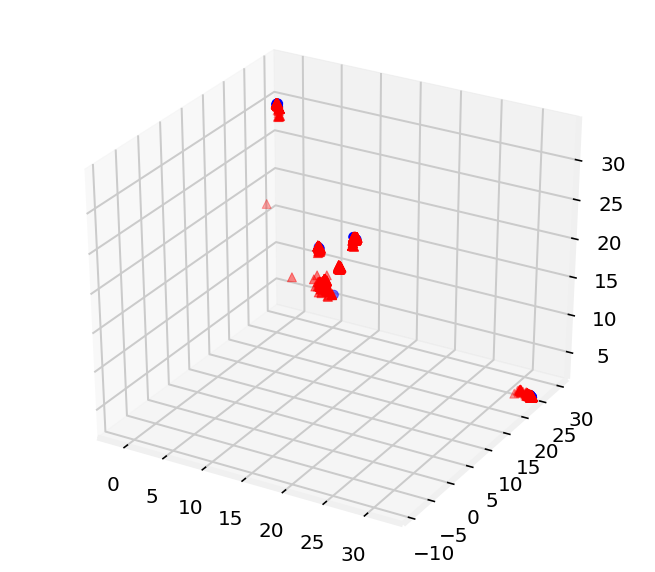

In [2]:


# # Set up VAE.
# with tf.device('/gpu:0'):
intermediate_dim = 1000
encoding_dim = 3
#guess: latent_dim ~ latent dimension
latent_dim = encoding_dim
epsilon_std = 1.0
nb_epoch = 250

# guess refer: https://keras.io/models/model/
# one viral sequence as input.
x = Input(shape=(training_array.shape[1],))
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(latent_dim, ), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


def vae_loss(x, x_decoded_mean):
    xent_loss = training_array.shape[1] * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
x_decoded_mean = Dense(training_array.shape[1], activation='sigmoid')(z_mean)

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='adam', loss=vae_loss)

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
encoder_var = Model(x, z_log_var)

# from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(training_array)

early_stopping = EarlyStopping(monitor="val_loss", patience=2)

# build the decoder, the encoding_dim (dimension of input of decoder) should be 
# the same as the latent variable.
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = vae.layers[-1]
# create the decoder model
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))


# Train the VAE to learn weights
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=nb_epoch,
        validation_data=(x_test, x_test),
        callbacks=[early_stopping],
       )

save_model(vae, 'trained_models/vae')
save_model(encoder, 'trained_models/encoder')
save_model(decoder, 'trained_models/decoder')


with open('trained_models/vae.yaml', 'r+') as f:
    yaml_spec = f.read()
    
#load_model is a class in custom.py at the current directory
vae = load_model('./trained_models/vae')
encoder = load_model('./trained_models/encoder')
decoder = load_model('./trained_models/decoder')

training_embeddings_mean = encoder.predict(training_array)
training_embeddings_mean.shape

lowp, highp = get_density_interval(99, training_embeddings_mean, axis=0)

lowp, highp
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1, projection='3d')

# **************************************
#split training_embeddings_mean into 2 groups: common and diff; Shape = ([:],0 to 2)
# **************************************
training_embeddings_mean_common = np.ndarray(shape=(len(chk_metadata_id_common_idxs), 3),dtype=np.float) 
tempItem_training_embeddings_mean = [training_embeddings_mean[i] for i in chk_metadata_id_common_idxs]
for i, seq in enumerate(tempItem_training_embeddings_mean):
    training_embeddings_mean_common[i, :] = list(tempItem_training_embeddings_mean[i])

training_embeddings_mean_diff = np.ndarray(shape=(len(chk_metadata_id_diff_idxs), 3),dtype=np.float) 
tempItem_training_embeddings_mean2 = [training_embeddings_mean[i] for i in chk_metadata_id_diff_idxs]
for i, seq in enumerate(tempItem_training_embeddings_mean2):
    training_embeddings_mean_diff[i, :] = list(tempItem_training_embeddings_mean2[i])
    
#sequences length: 6283 (as no filter for Complete and Human record.)
# training_embeddings_mean[:, 0] [ 7.535975  -4.355269  -4.226715  ...  7.428951   7.0916295  7.144496 ]

ax.scatter(training_embeddings_mean_common[:, 0], 
           training_embeddings_mean_common[:, 1], 
           training_embeddings_mean_common[:, 2], 
           c='red', marker='^')     

ax.scatter(training_embeddings_mean_diff[:, 0], 
           training_embeddings_mean_diff[:, 1], 
           training_embeddings_mean_diff[:, 2], 
           c='blue', marker='o')     

# set the x,y,z limit    
ax.set_xlim(lowp[0], highp[0])
ax.set_ylim(lowp[1], highp[1])
ax.set_zlim(lowp[2], highp[2])
ax.set_facecolor('white')
plt.show()
